# Capstone Two #

## Predicting Test Performance for Specialised High School Admissions ##

Performance on the Specialized High School Admissions Test (SHSAT) determines eligibility to one of the eight specialized high schools in New York City. It is administered by the New York City Department of Education (DOE) to about a third of the city’s 8th graders, with 5,000 receiving admissions offers. Of major concern is the racial & ethnic breakdown of admitted students, showing significant underrepresentation from black and latinx students. 

The goal of this analysis is to elicit which factors predict performance on the SHSAT. These factors will serve as beacons to direct or draw services, whether education-based or otherwise, towards improving the percentage of black and latinx students admitted to the specialized high schools. 

This approach aims to quantify which variables lead to admissions offers beyond prior proxies: English Language Learners, Students with Disabilities, Students on Free/Reduced Lunch, and Students with Temporary Housing.

In [2]:
# Load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import urllib.request
%matplotlib inline

### Data Collection & Loading Data Sets ###

Two main data sets will be used:

*2016 School Explorer*  
This dataset consists of 1272 schools in New York city, and 161 variables, provided via kaggle. Primarily, it’s school descriptors, e.g. grades, race & ethnicity student percentages, high/low performing percentages of students. Data is available as a single csv file.

*2017-2018 SHSAT Admissions Test Offers By Sending School*  
This dataset consists of the 2017 SHSAT results, published by NYC in 2018. All test takers are north of 28,000, grade 8 students, Test takers and offers received are grouped by school. Data is available as a single csv file from the NYC Open Data portal.

In [4]:
# Downloading the 2016 School Explorer data set to raw folder
url = 'https://storage.googleapis.com/kagglesdsdata/datasets%2F33225%2F44131%2F2016%20School%20Explorer.csv?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1595273466&Signature=fk6%2BI64ZSKXeenOP24Hsst9gNp2z3gFDGnz1rSXzcrnS874EFfR1VjUPVu0mCoN0bwXxJ7udjKpGlD51QLqiolRTpt9t%2F6ko672nNzd2KU0zJd4xRN8yW4Ouk1XxbCCTN2u6In241T1%2BY1RMpSp5rQgko83zQtwPClQPsl%2BWynlztsHV1aWF2K1J6MUy1SBaXyHvTSXBiMp1G2FvCoVjRVyjkXwV94Xgayi8Zgs3ISjyVUZn3yYzuyarl8NUwSnryWnfCE1debgt5z9AP5aTv7IbUA297hpYAhHZR0NjtKMwoadxypbWbBZ6cUTgI8KT4L4q8LdCgJ6SDJolkJERaQ%3D%3D'
file_explorer = '../data/raw/2016_School_Explorer.csv'
urllib.request.urlretrieve(url, file_explorer)

# Downloading the 2017-2018 SHSAT data set to raw folder
url = 'https://data.cityofnewyork.us/resource/vsgi-eeb5.csv'
file_offers = '../data/raw/2017-2018_SHSAT_Admissions_Test_Offers_By_Sending_School.csv'
urllib.request.urlretrieve(url, file_offers)

In [5]:
# Loading data sets
df_explorer = pd.read_csv(file_explorer)
df_offers = pd.read_csv(file_offers)

In [5]:
df_explorer.head(3)

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),...,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Grade 8 Math 4s - American Indian or Alaska Native,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged
0,NaN,NaN,NaN,P.S. 015 ROBERTO CLEMENTE,310100010015,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,NaN,P.S. 019 ASHER LEVY,310100010019,01M019,1,40.729892,-73.984231,"185 1ST AVE NEW YORK, NY 10003",...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,NaN,P.S. 020 ANNA SILVER,310100010020,01M020,1,40.721274,-73.986315,"166 ESSEX ST NEW YORK, NY 10002",...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_offers.head()

,feeder_school_dbn,feeder_school_name,count_of_students_in_hs_admissions,count_of_testers,count_of_offers
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,58.0,6,0-5
1,01M140,P.S. 140 NATHAN STRAUS,67.0,6,0-5
2,01M184,P.S. 184M SHUANG WEN,88.0,67,23
3,01M188,P.S. 188 THE ISLAND SCHOOL,59.0,0-5,0-5
4,01M301,"TECHNOLOGY, ARTS, AND SCIENCES STUDIO",51.0,11,0-5


### Data Definitions ###

Generally exploring both datasets to understand what's in them.

In [7]:
df_explorer.columns

Index(['Adjusted Grade', 'New?', 'Other Location Code in LCGMS', 'School Name',
       'SED Code', 'Location Code', 'District', 'Latitude', 'Longitude',
       'Address (Full)',
       ...
       'Grade 8 Math - All Students Tested', 'Grade 8 Math 4s - All Students',
       'Grade 8 Math 4s - American Indian or Alaska Native',
       'Grade 8 Math 4s - Black or African American',
       'Grade 8 Math 4s - Hispanic or Latino',
       'Grade 8 Math 4s - Asian or Pacific Islander',
       'Grade 8 Math 4s - White', 'Grade 8 Math 4s - Multiracial',
       'Grade 8 Math 4s - Limited English Proficient',
       'Grade 8 Math 4s - Economically Disadvantaged'],
      dtype='object', length=161)

In [8]:
df_explorer.shape

(1272, 161)

In [9]:
df_explorer.describe().T

,count,mean,std,min,25%,50%,75%,max
SED Code,1272.0,3.286698e+11,1.222022e+10,3.075000e+11,3.208752e+11,3.315004e+11,3.424000e+11,3.531009e+11
District,1272.0,1.613522e+01,9.245270e+00,1.000000e+00,9.000000e+00,1.500000e+01,2.400000e+01,3.200000e+01
Latitude,1272.0,4.073454e+01,8.660234e-02,4.050780e+01,4.066950e+01,4.072299e+01,4.081563e+01,4.090346e+01
Longitude,1272.0,-7.391835e+01,8.057649e-02,-7.424402e+01,-7.395706e+01,-7.392057e+01,-7.387926e+01,-7.370892e+01
Zip,1272.0,1.081572e+04,5.295889e+02,1.000100e+04,1.045200e+04,1.120300e+04,1.123200e+04,1.169400e+04
...,...,...,...,...,...,...,...,...
Grade 8 Math 4s - Asian or Pacific Islander,1272.0,1.984277e+00,1.284133e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.460000e+02
Grade 8 Math 4s - White,1272.0,9.709119e-01,6.880223e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
Grade 8 Math 4s - Multiracial,1272.0,2.358491e-03,8.411582e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
Grade 8 Math 4s - Limited English Proficient,1272.0,1.595912e-01,1.321195e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+01


We can tell that there are 161 variables in the 2016 School Explorer data set with 1,272 rows of data consisting of physical descriptors and descriptive statistics information for all of the schools.

In [10]:
df_offers.columns

Index(['feeder_school_dbn', 'feeder_school_name',
       'count_of_students_in_hs_admissions', 'count_of_testers',
       'count_of_offers'],
      dtype='object')

In [11]:
df_offers.shape

(594, 5)

In [12]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_dbn                   594 non-null    object 
 1   feeder_school_name                  594 non-null    object 
 2   count_of_students_in_hs_admissions  593 non-null    float64
 3   count_of_testers                    594 non-null    object 
 4   count_of_offers                     594 non-null    object 
dtypes: float64(1), object(4)
memory usage: 23.3+ KB


The 2017-2018 SHSAT Admissions Test Offers By Sending School has 5 variables with 594 rows of data consisting of names and descriptive statistics for all of the schools. This makes sense because not all schools send students to the SHSAT.

**Initial Data Cleaning**

Let's determine the null values and then appropriately address what to do with them.

In [13]:
nas=pd.DataFrame(df_explorer.isnull().sum().sort_values(ascending=False)/len(df_explorer),columns = ['Percent'])
pos = nas['Percent'] > 0
nas[pos]

,Percent
Other Location Code in LCGMS,0.999214
Adjusted Grade,0.998428
New?,0.978774
School Income Estimate,0.311321
Student Achievement Rating,0.067610
Supportive Environment Rating,0.062893
Collaborative Teachers Rating,0.059748
Rigorous Instruction Rating,0.059748
Trust Rating,0.057390
Strong Family-Community Ties Rating,0.057390


We can see that the *explorer* data set has three columns almost entirely of null values. These can be filled with an appropriate value for the data type of those columns.

In [14]:
nas=pd.DataFrame(df_offers.isnull().sum().sort_values(ascending=False)/len(df_offers),columns = ['Percent'])
pos = nas['Percent'] > 0
nas[pos]

,Percent
count_of_students_in_hs_admissions,0.001684


The *offers* data set is pretty clean and doesn't need to have null values addressed.

In [6]:
# Determine existing values of high-NaN columns identified above, for 2016 School Explorer dataframe
print(df_explorer['Other Location Code in LCGMS'].describe())
print(df_explorer['Adjusted Grade'].describe())
df_explorer['New?'].describe()

count          1
unique         1
top       75k372
freq           1
Name: Other Location Code in LCGMS, dtype: object
count     2
unique    1
top       x
freq      2
Name: Adjusted Grade, dtype: object


count     27
unique     1
top        x
freq      27
Name: New?, dtype: object

In [7]:
# Replacing the null values with 'n' for no/ne
df_explorer['Other Location Code in LCGMS'].fillna('n', inplace=True)
df_explorer['Adjusted Grade'].fillna('n', inplace = True)
df_explorer['New?'].fillna('n', inplace=True)

The school income estimate column, which has more than 30% of its values equal to null, seems to not be a numeric data type.

In [8]:
df_explorer['School Income Estimate'].describe()

count             876
unique            876
top       $33,472.14 
freq                1
Name: School Income Estimate, dtype: object

In [9]:
df_explorer['School Income Estimate Numeric'] = df_explorer['School Income Estimate'].str.replace('$','').str.replace(',','').astype(float)

In [10]:
df_explorer['School Income Estimate Numeric'].fillna(0, inplace=True)
df_explorer['School Income Estimate Numeric'].isnull().sum()

0

Nice!

### Exploratory Data Analysis ###

Building data profile tables and plots, exploring data relationships, and identifying & creating features.

In [11]:
df_explorer.iloc[:,121:141].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 20 columns):
 #   Column                                              Non-Null Count  Dtype
---  ------                                              --------------  -----
 0   Grade 7 ELA - All Students Tested                   1272 non-null   int64
 1   Grade 7 ELA 4s - All Students                       1272 non-null   int64
 2   Grade 7 ELA 4s - American Indian or Alaska Native   1272 non-null   int64
 3   Grade 7 ELA 4s - Black or African American          1272 non-null   int64
 4   Grade 7 ELA 4s - Hispanic or Latino                 1272 non-null   int64
 5   Grade 7 ELA 4s - Asian or Pacific Islander          1272 non-null   int64
 6   Grade 7 ELA 4s - White                              1272 non-null   int64
 7   Grade 7 ELA 4s - Multiracial                        1272 non-null   int64
 8   Grade 7 ELA 4s - Limited English Proficient         1272 non-null   int64
 9   Grade 7 ELA 4s - Ec

Given the test-takers in the 2017-2018's df_offers are a year away from taking the test in 2016's df_explorer, I'll focus on the 7th graders.

df_explorer has 20 variables with information 7th graders. This data is broken up into two kinds of information, ELA (English Language Arts) & Math. Scoring on these tests top out at 4, with 1 representing the worst score.

Therefore, the best students are in the '4s' columns shown above. 

Summary of columns:

- All students tested
- All students with 4 scores
- American Indian or Alaska Native with 4 scores
- Black or African American students with 4 scores
- Hispanic or Latino students with 4 scores
- Asian or Pacific Islander students with 4 scores
- White students with 4 scores
- Multiracial students with 4 scores
- Limited English Proficient students with 4 scores
- Economically Disadvantaged with 4 scores


In [75]:
# Subsetting df_explorer data for just the 7th graders
df_ela = df_explorer.iloc[:,121:131]
df_math = df_explorer.iloc[:,131:141]

In [76]:
ethnicity = ['Black','Latino','Asian','White']
df_ela_totals = pd.DataFrame({'ethnicity':ethnicity,'totals':[i for i in df_ela.iloc[:,3:7].sum()]})
df_math_totals = pd.DataFrame({'ethnicity':ethnicity,'totals':[i for i in df_math.iloc[:,3:7].sum()]})
print(df_math.sum()[0], df_ela.sum()[1], df_math.sum()[1])

69053 8320 10888


In 2016, the total number of 7th graders in NYC Middle Schools was **69,053**. Of those, **8,320** had ELA scores of 4, and **10,888** had Math scores of 4.

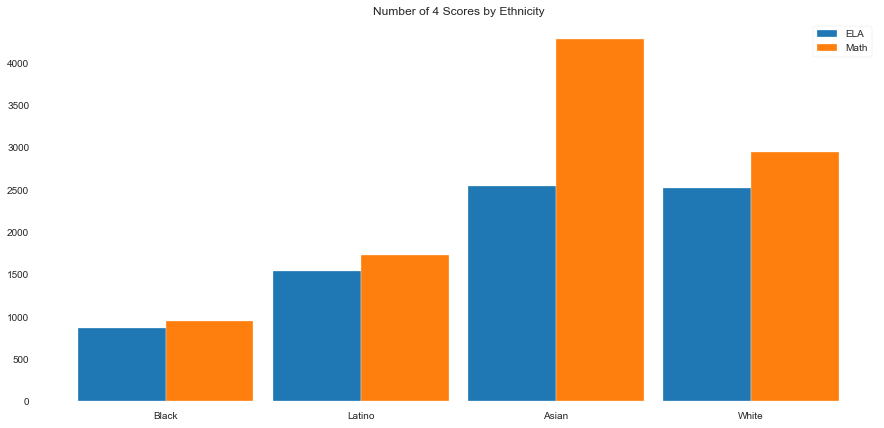

In [77]:
_ = plt.figure(figsize = (15,7))
_ = plt.title('Number of 4 Scores by Ethnicity')
w = 0.45
ela_bar = plt.bar(np.arange(len(df_ela_totals)), df_ela_totals.totals, width = w, align = 'center', label = 'ELA')
math_bar = plt.bar(np.arange(len(df_ela_totals))+w, df_math_totals.totals, width = w, align = 'center', 
                   label = 'Math')
_ = plt.xticks(np.arange(4)+0.225, ethnicity)
_ = plt.legend(handles=[ela_bar,math_bar], loc = 'upper right')

Using the assumption that those ethnicities that have the majority of the 4 scores will, in turn, perform well on the aptitude test for the specialized high school, we can see why Black & Latino may receive less admittance offers based on these limited criteria.

In [13]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_dbn                   594 non-null    object 
 1   feeder_school_name                  594 non-null    object 
 2   count_of_students_in_hs_admissions  593 non-null    float64
 3   count_of_testers                    594 non-null    object 
 4   count_of_offers                     594 non-null    object 
dtypes: float64(1), object(4)
memory usage: 23.3+ KB


df_offers contains all middle school 8th graders who took the SHSAT. 

In both the count_of_testers and count_of_offers columns, a school with less that 5 students, the value reads as '0-5' 8th graders.

In [14]:
testers = pd.to_numeric(df_offers.count_of_testers[df_offers.count_of_testers != '0-5'])
offers = pd.to_numeric(df_offers.count_of_offers[df_offers.count_of_offers != '0-5'])

In [15]:
print(len(testers),testers.sum(), len(offers), offers.sum())
print(len(df_offers.count_of_testers[df_offers.count_of_testers == '0-5']), 
      len(df_offers.count_of_offers[df_offers.count_of_offers == '0-5']))

537 25349 121 4018
57 473


**537** NYC Middle Schools sent at least 6 students to SHSAT for a total of **25,349** 8th graders taking the test. **57** schools send 0-5 8th graders to take the test. **121** NYC Middle Schools saw at least 6 of their students receive offers, for a total of **4,018** 8th graders having received an offer. **473** schools saw 0-5 of their 8th graders receive an offer.

**Merging Datasets**

Using the DBN & Location Code I'll merge df_explorer data for 7th graders to the df_offers information for SHSAT testers.

In [16]:
df_exp_subset = df_explorer.loc[:,['Location Code', 'District', 'Latitude', 'Longitude', 'Percent ELL', 
                                       'Percent Asian','Percent Black', 'Percent Hispanic', 
                                   'Percent Black / Hispanic','Percent White', 'Average ELA Proficiency', 
                                   'Average Math Proficiency', 'Grade 7 ELA - All Students Tested', 
                                   'Grade 7 ELA 4s - All Students', 'Grade 7 Math - All Students Tested', 
                                   'Grade 7 Math 4s - All Students']]

In [17]:
df_main = df_offers.merge(df_exp_subset, left_on = 'feeder_school_dbn', right_on = 'Location Code')

In [18]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 590
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_dbn                   591 non-null    object 
 1   feeder_school_name                  591 non-null    object 
 2   count_of_students_in_hs_admissions  591 non-null    float64
 3   count_of_testers                    591 non-null    object 
 4   count_of_offers                     591 non-null    object 
 5   Location Code                       591 non-null    object 
 6   District                            591 non-null    int64  
 7   Latitude                            591 non-null    float64
 8   Longitude                           591 non-null    float64
 9   Percent ELL                         591 non-null    object 
 10  Percent Asian                       591 non-null    object 
 11  Percent Black                       591 non-n

Looks like **2** of the schools in df_offers aren't in the df_explorer data.

I'll also add a few more columns:

- “Percentage of SHSAT takers receiving an offer” (Numbers of SHSAT takers/Number of Offers by school)
- “The total number of Black/Hispanic students in Grade 8” (Number of 8th graders * Percent Black / Hispanic)
- “Percentage of students who did the SHSAT” (Number of SHSAT takers/Number of 8th graders)
- “Average Mark” (the average of Average ELA Proficiency and Average Math Proficiency)
- “Percent of students with Level 4 ELA in Grade 7 (Grade 7 ELA 4s - All Students/Grade 7 ELA - All Students Tested)
- “Percent of students with Level 4 Math in Grade 7 (Grade 7 Math 4s - All Students/Grade 7 Math - All Students Tested)
- “Percent of students with Level 4 in Grade 7” (average of 4 percentages ELA and Math in Grade 7)
- “Average number of Level 4 students” (Grade 7 ELA 4s - All Students + Grade 7 Math 4s - All Students)/2

In [19]:
# Filling NaN
df_main['Average ELA Proficiency'].fillna(0, inplace = True)
df_main['Average Math Proficiency'].fillna(0, inplace = True)

# Modifying data types
df_main['PctELL'] = df_main['Percent ELL'].str.extract('(\d+)').astype(int)
df_main['PctAsian'] = df_main['Percent Asian'].str.extract('(\d+)').astype(int)
df_main['PctBlack'] = df_main['Percent Black'].str.extract('(\d+)').astype(int)
df_main['PctHispanic'] = df_main['Percent Hispanic'].str.extract('(\d+)').astype(int)
df_main['PctWhite'] = df_main['Percent White'].str.extract('(\d+)').astype(int)
df_main['PctBlackOrHispanic'] = df_main['Percent Black / Hispanic'].str.extract('(\d+)').astype(int)

df_main['NumTestTakers'] = pd.to_numeric(df_main.count_of_testers, errors = 'coerce', downcast = 'signed')
df_main['NumSpecializedOffers'] = pd.to_numeric(df_main.count_of_offers, errors = 'coerce', downcast = 'signed')
df_main.NumTestTakers.fillna(0, inplace = True)
df_main.NumSpecializedOffers.fillna(0, inplace = True)

### Feature Engineering & Preliminary Reports ###

In [20]:
# Adding calculated columns
df_main['PctOffersByStudent'] = round((df_main.NumSpecializedOffers / df_main.NumTestTakers) * 100, 0)
df_main.PctOffersByStudent.fillna(0, inplace = True)

df_main['TotalGrade8BlHisp'] = round((df_main.count_of_students_in_hs_admissions * df_main.PctBlackOrHispanic) 
                                     / 100)
df_main['PerDidSHSAT'] = round((df_main.NumTestTakers / df_main.count_of_students_in_hs_admissions) * 100)
df_main['AvgMark'] = round((df_main['Average ELA Proficiency'] + df_main['Average Math Proficiency'])/2, 2)
df_main['PctScore4ELA'] = round((df_main['Grade 7 ELA 4s - All Students'] / 
                                 df_main['Grade 7 ELA - All Students Tested']) * 100)
df_main['PctScore4Math'] = round((df_main['Grade 7 Math 4s - All Students'] / 
                                   df_main['Grade 7 Math - All Students Tested']) * 100)
df_main['AvgScore4'] = round((df_main['Grade 7 ELA 4s - All Students'] + 
                             df_main['Grade 7 Math 4s - All Students']) / 2, 1)
df_main['PctScore4'] = round((df_main.PctScore4ELA + df_main.PctScore4Math) / 2)

df_main.PctScore4ELA.fillna(0, inplace = True)
df_main.PctScore4Math.fillna(0, inplace = True)
df_main.PctScore4.fillna(0, inplace = True)

In [190]:
# Generating a Profile Report as a general overview of the data.
profile = ProfileReport(df_main, title = 'Capstone Two Profile Report')
profile.to_file("../reports/CapstoneTwo.html")
profile.to_notebook_iframe()

# Generating an explorative report
profile_exp = ProfileReport(df_main, title='Capstone Two Explorative Profiling Report', explorative=True)
profile_exp.to_file("../reports/CapstoneTwo_Explorative.html")

**Schools with highest number of test takers**

What we're seeing in this next plot is that those schools that send the most 8th graders to the SHSAT, have less of their school, percentage-wise, represented by Black or Latino students.

Interestingly, there is a high percentage of Black/Hispanic students (The William W. Niles school (82%), and The Eugenio Maria De Hostos school(78%), near the middle of the pack and the lowest, respectively.

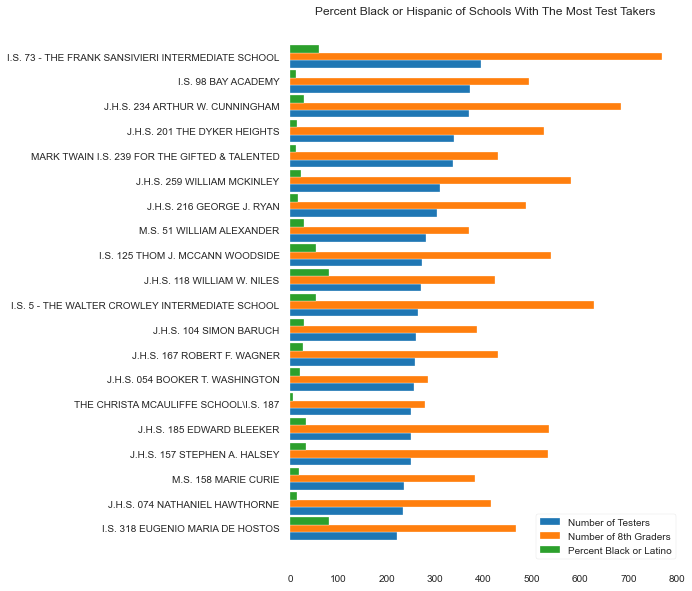

In [21]:
most_testtakers = df_main.nlargest(20, 'NumTestTakers', keep = 'all')
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent Black or Hispanic of Schools With The Most Test Takers')
h = 0.3
testers = plt.barh(np.arange(len(most_testtakers))+h, most_testtakers.NumTestTakers, height = h, 
                   label = 'Number of Testers')
eight_graders = plt.barh(np.arange(len(most_testtakers)), most_testtakers.count_of_students_in_hs_admissions, 
                         height = h, label = 'Number of 8th Graders')
pct_blk_hisp = plt.barh(np.arange(len(most_testtakers))-h, most_testtakers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(most_testtakers)), most_testtakers.feeder_school_name)
_ = plt.legend(handles=[testers,eight_graders,pct_blk_hisp], loc = 'best')

**Schools with the least number of test takers**

Nearly all of the schools with the least number of test takers in 2017 (55) had low average marks (average of AvgELA and AvgMath). 

Also, most schools had a high percentage of Black or Hispanic students.

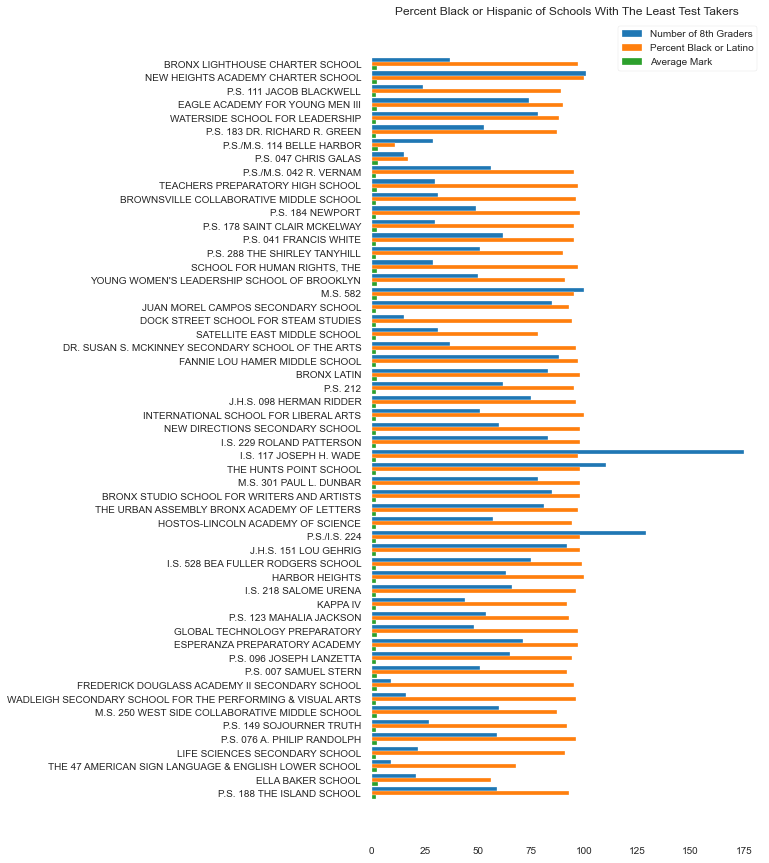

In [22]:
least_testtakers = df_main[df_main.NumTestTakers == 0]
_ = plt.figure(figsize = (7,15))
_ = plt.title('Percent Black or Hispanic of Schools With The Least Test Takers')
h = 0.3
eighth_graders = plt.barh(np.arange(len(least_testtakers))+h, least_testtakers.count_of_students_in_hs_admissions, 
                         height = h, label = 'Number of 8th Graders')
pct_blk_hisp = plt.barh(np.arange(len(least_testtakers)), least_testtakers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
average_mark = plt.barh(np.arange(len(least_testtakers))-h, least_testtakers.AvgMark, height = h, 
                        label = 'Average Mark')
plt.yticks(np.arange(len(least_testtakers)), least_testtakers.feeder_school_name)
_ = plt.legend(handles=[eighth_graders,pct_blk_hisp,average_mark], loc = 'upper right')

**Numbers of Offers by school**

The top 25 schools with the most offers received had lower percentages of Black or Hispanic students (highest percentage is at Frank Sansivieri school with 59% Black or Hispanic students).

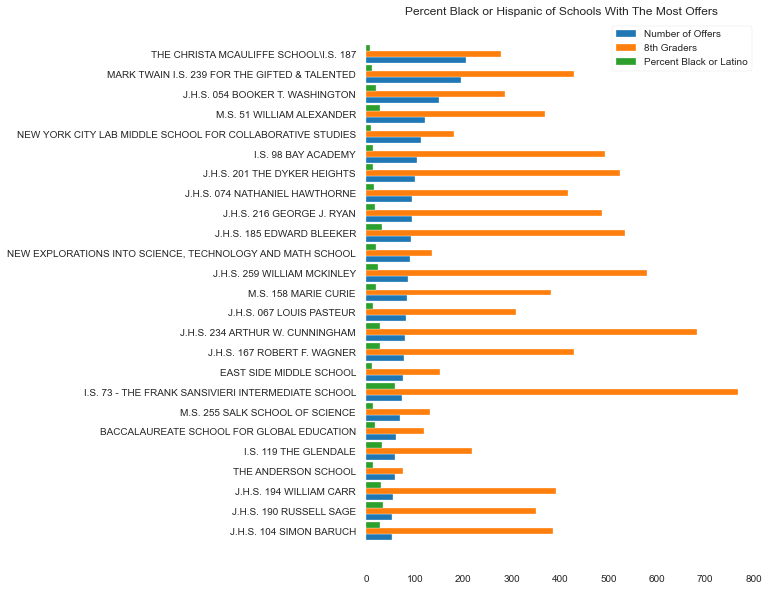

In [23]:
most_offers = df_main.sort_values(by = 'NumSpecializedOffers', ascending=False).head(25)
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent Black or Hispanic of Schools With The Most Offers')
h = 0.3
highest_offers = plt.barh(np.arange(len(most_offers))+h, most_offers.NumSpecializedOffers, height = h, 
                          label = 'Number of Offers')
eighth_graders = plt.barh(np.arange(len(most_offers)), most_offers.count_of_students_in_hs_admissions, height = h, 
                        label = '8th Graders')
pct_blk_hisp = plt.barh(np.arange(len(most_offers))-h, most_offers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(most_offers)), most_offers.feeder_school_name)
_ = plt.legend(handles=[highest_offers, eighth_graders,pct_blk_hisp], loc = 'upper right')

**Highest Percentage of Offers for the Number of Test Takers**

Below are the top 20 schools that had the highest percentage of offers for the number of test takers, representing how successful that school was as to the number of students that were admitted to the specialized high school.

The Christa McAuliffe School had the msot success with 82% of 251 students taking the test getting an offer.

The schools scoring best at the percentage of students actually getting an offer are very low in Black or Latinx student percentages (the exception is the small Columbia Secondary School with 64% Black/Latinos).

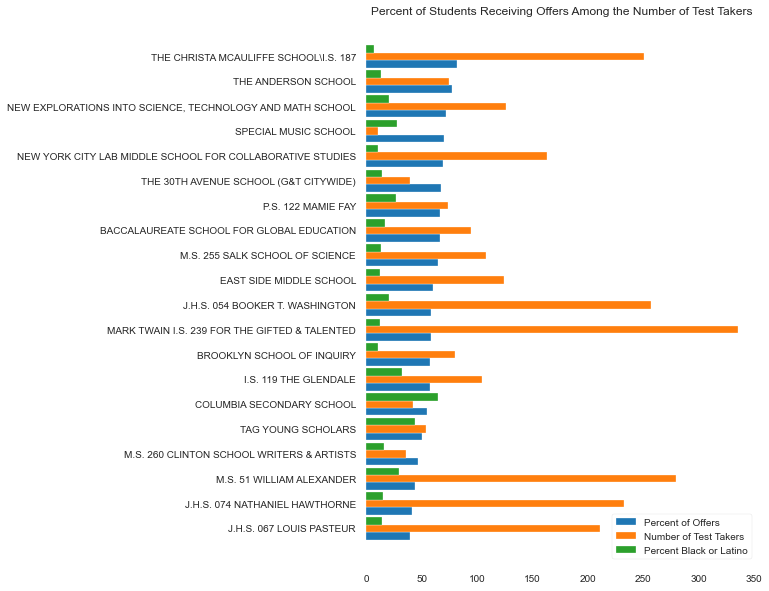

In [24]:
pct_offers = df_main.sort_values(by = 'PctOffersByStudent', ascending=False).head(20)
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent of Students Receiving Offers Among the Number of Test Takers')
h = 0.3
pct_of_offers = plt.barh(np.arange(len(pct_offers))+h, pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
num_test_takers = plt.barh(np.arange(len(pct_offers)), pct_offers.NumTestTakers, height = h, 
                           label = 'Number of Test Takers')
pct_blk_hisp = plt.barh(np.arange(len(pct_offers))-h, pct_offers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(pct_offers)), pct_offers.feeder_school_name)
_ = plt.legend(handles=[pct_of_offers,num_test_takers,pct_blk_hisp], loc = 'best')

Below are the top 20 schools that had the highest percentage of offers for the number of test takers, along with the percentage of the school that was made up of 4 score students and their average proficiency (Average Mark).

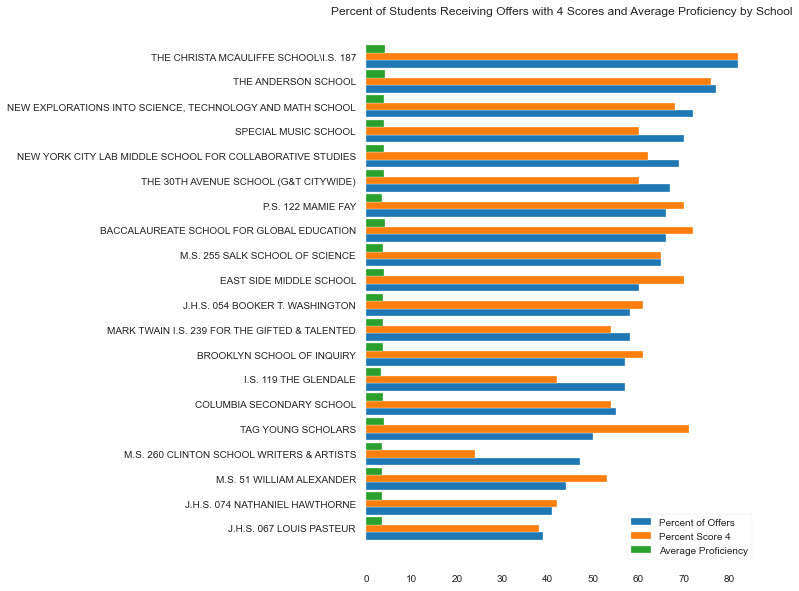

In [25]:
_ = plt.figure(figsize = (7,10))
_ = plt.title('Percent of Students Receiving Offers with 4 Scores and Average Proficiency by School')
h = 0.3
pct_of_offers = plt.barh(np.arange(len(pct_offers))+h, pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
pct_score_4 = plt.barh(np.arange(len(pct_offers)), pct_offers.PctScore4, height = h, 
                           label = 'Percent Score 4')
avg_mark = plt.barh(np.arange(len(pct_offers))-h, pct_offers.AvgMark, height = h, 
                        label = 'Average Proficiency')
_ = plt.gca().invert_yaxis()
plt.yticks(np.arange(len(pct_offers)), pct_offers.feeder_school_name)
_ = plt.legend(handles=[pct_of_offers,pct_score_4,avg_mark], loc = 'best')

**Least Percentage of Offers for the Number of Test Takers**

Of those schools which had at least 6 offrs, the 20 schools with least success are shown below. 

Two of the largest schools that are predominatly Black/Hispanic and sent many students to the test are J.H.S 118 William W. Niles school @ 424 8th graders (82% Black/Hispanic) and I.S. 318 Eugenio Maria De Hostos @ 467 8th graders (78% Black/Hispanic).

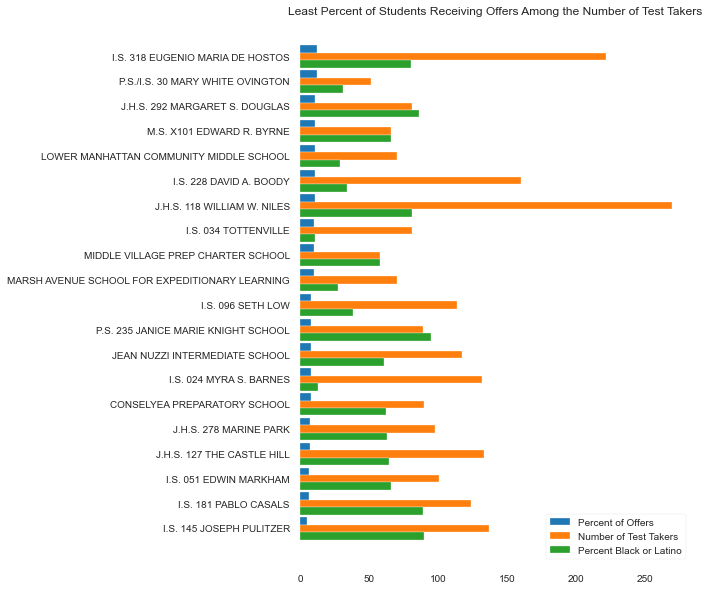

In [26]:
least_pct_offers = df_main[df_main.NumSpecializedOffers > 0].sort_values(by = 'PctOffersByStudent').head(20)
_ = plt.figure(figsize = (7,10))
_ = plt.title('Least Percent of Students Receiving Offers Among the Number of Test Takers')
h = 0.3
least_pct_of_offers = plt.barh(np.arange(len(least_pct_offers))+h, least_pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
lnum_test_takers = plt.barh(np.arange(len(least_pct_offers)), least_pct_offers.NumTestTakers, height = h, 
                           label = 'Number of Test Takers')
lpct_blk_hisp = plt.barh(np.arange(len(least_pct_offers))-h, least_pct_offers.PctBlackOrHispanic, height = h, 
                        label = 'Percent Black or Latino')
_ = plt.yticks(np.arange(len(least_pct_offers)), least_pct_offers.feeder_school_name)
_ = plt.legend(handles=[least_pct_of_offers,lnum_test_takers,lpct_blk_hisp], loc = 'best')

Almost all schools had a low percentage of Level4 students, and Average Marks. 

An interesting exception is the **Janice Marie Knight school**, which has a decent percentage of Score 4 students.

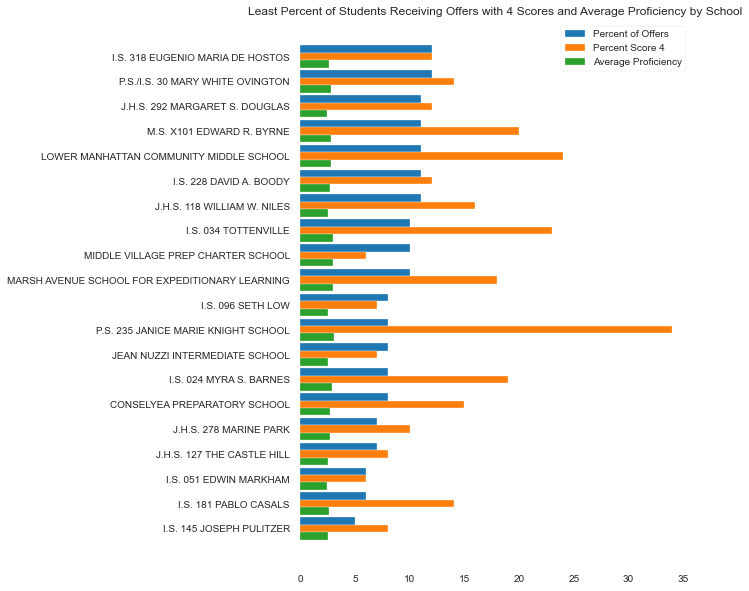

In [27]:
_ = plt.figure(figsize = (7,10))
_ = plt.title('Least Percent of Students Receiving Offers with 4 Scores and Average Proficiency by School')
h = 0.3
least_pct_of_offers = plt.barh(np.arange(len(least_pct_offers))+h, least_pct_offers.PctOffersByStudent, height = h, 
                         label = 'Percent of Offers')
lpct_score_4 = plt.barh(np.arange(len(least_pct_offers)), least_pct_offers.PctScore4, height = h, 
                           label = 'Percent Score 4')
lavg_mark = plt.barh(np.arange(len(least_pct_offers))-h, least_pct_offers.AvgMark, height = h, 
                        label = 'Average Proficiency')
#_ = plt.gca().invert_yaxis()
_ = plt.yticks(np.arange(len(least_pct_offers)), least_pct_offers.feeder_school_name)
_ = plt.legend(handles=[least_pct_of_offers,lpct_score_4,lavg_mark], loc = 'best')

**Boxplots**

This kind of plot doesn't really help explain relationships in this data but I thought I'd try it anyway.

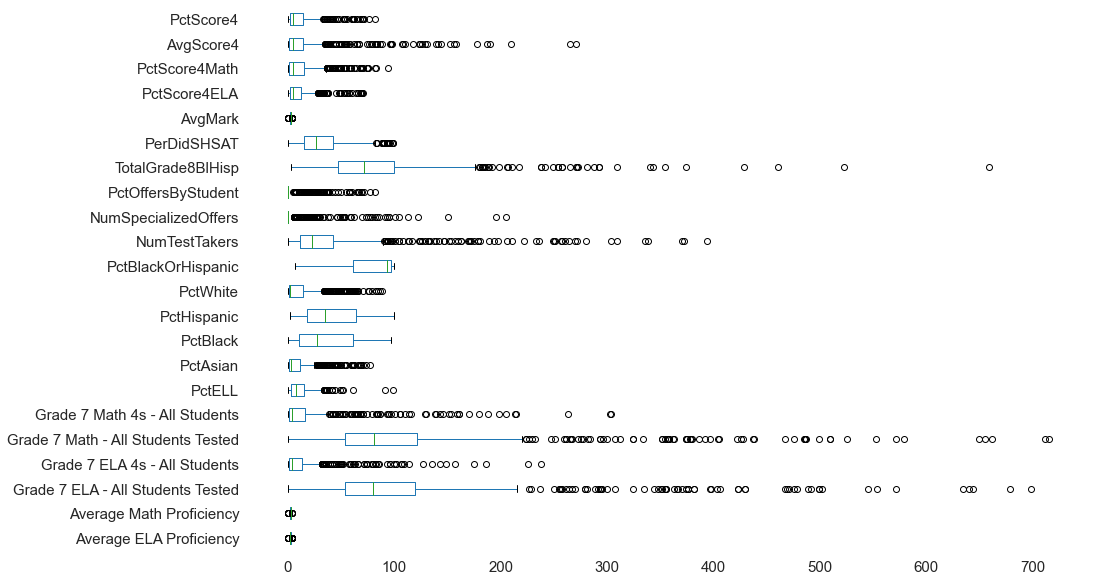

In [28]:
_ = plt.figure(figsize = (15,10))
boxplot = df_main.iloc[:,15:].boxplot(grid = False, vert = False,fontsize=15)

**HeatMap**

Looking at the Number of Specialized High School offers (NumSpecializedOffers) the correlations associated with the race of the student is astounding: Asian @ 0.54, **Black @ -0.31**, **Hispanic @ -0.25** & White @ 0.52

<AxesSubplot:>

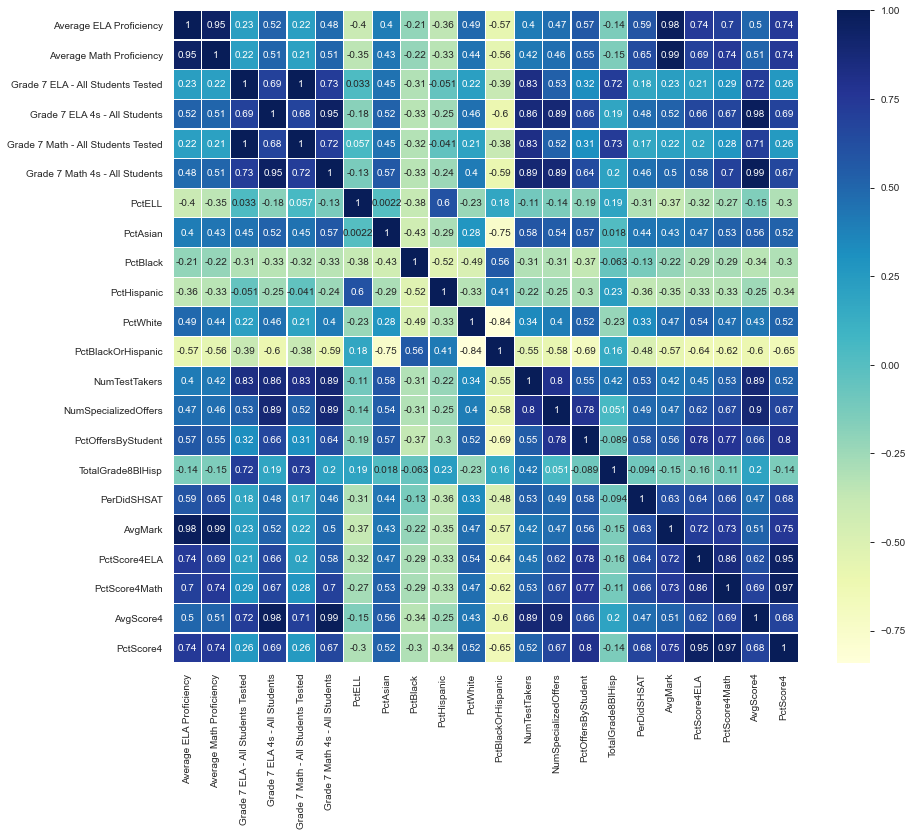

In [238]:
_ = plt.figure(figsize = (14,12))
sns.heatmap(df_main.iloc[:,15:].corr(), linewidths=.1, cmap="YlGnBu", annot=True)

**Pair Plot**

Here we can see the relationships between the number of Specialized High School offers (NumSpecializedOffers) and the race and percent of students who're scoring 4 on the ELA & Math tests.

There looks to be a strong (postive) relationship between the number of test takers and the number of of Specialized High School offers. This may be interesting to contemplate: the more students you send to the SHSAT, the more offers a school will get. 

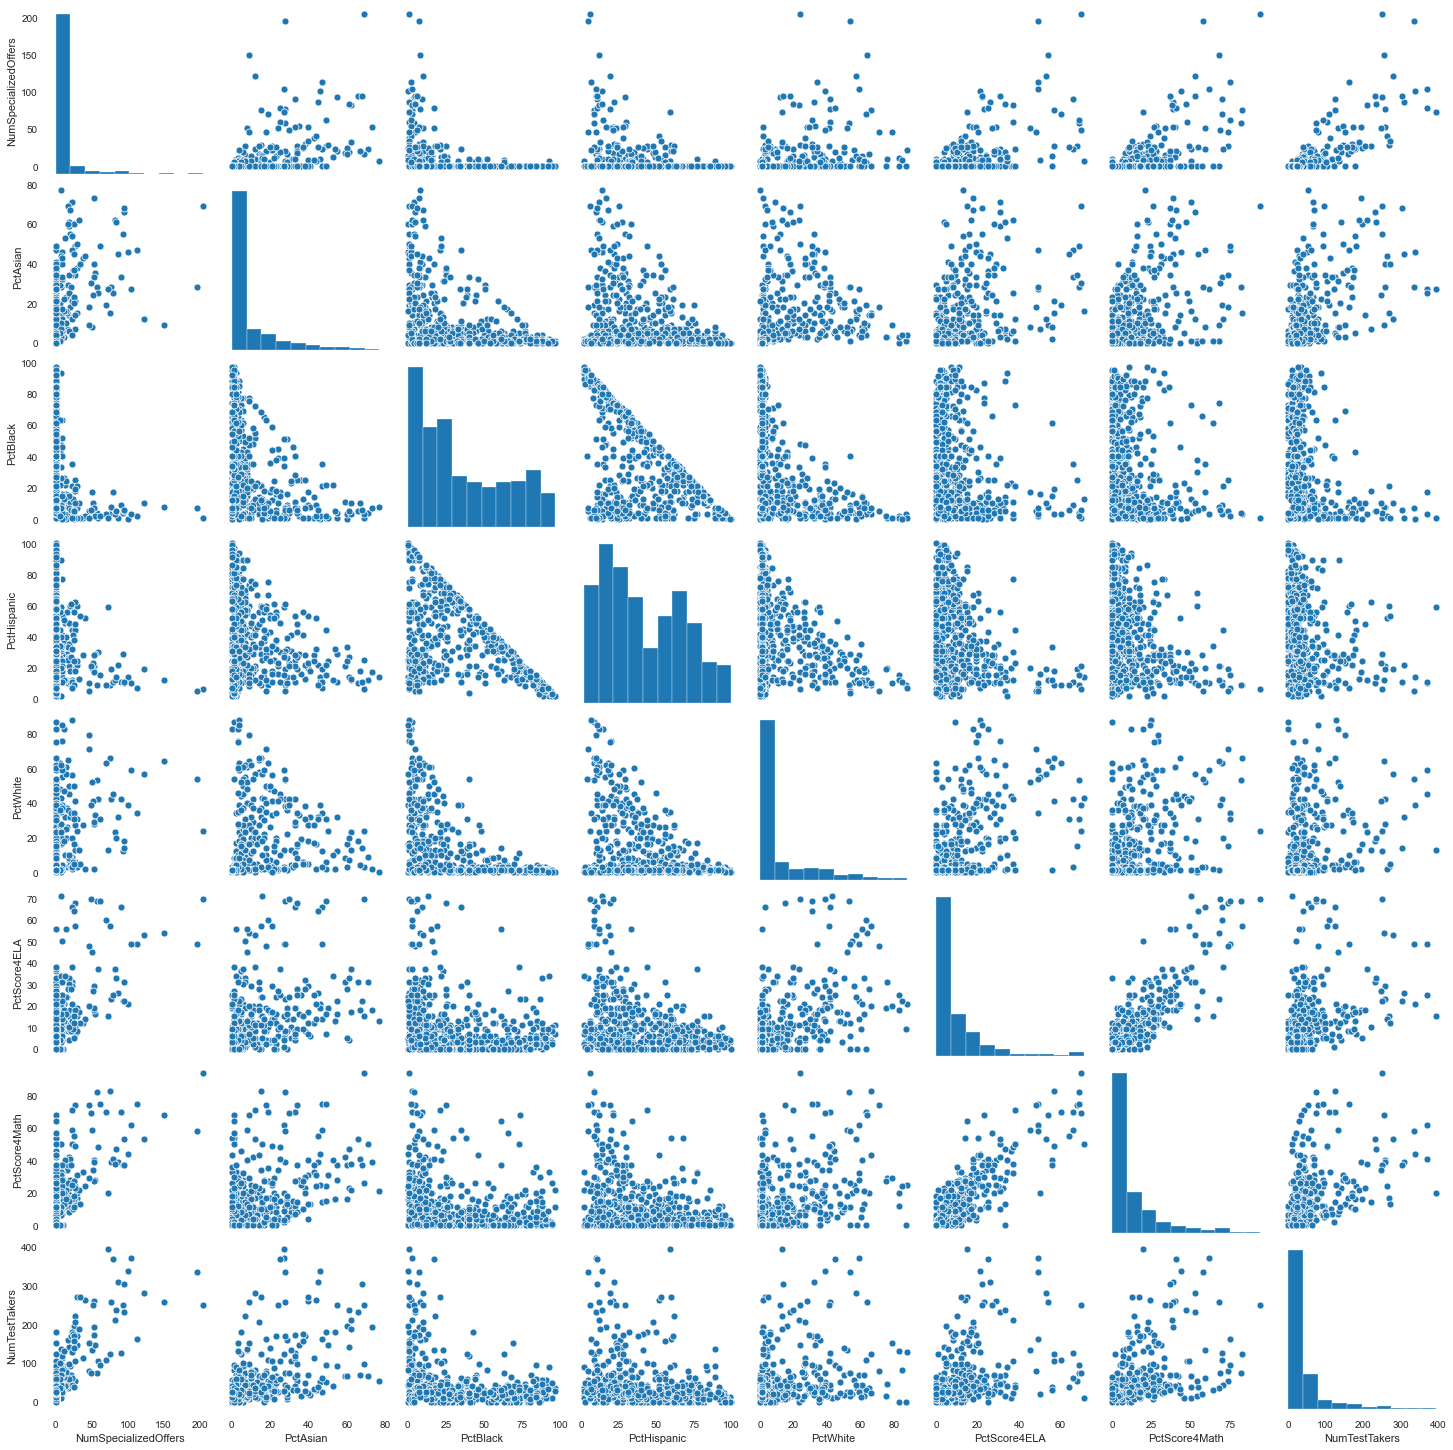

In [241]:
g = sns.pairplot(df_main, vars = ['NumSpecializedOffers', 'PctAsian', 'PctBlack', 'PctHispanic', 'PctWhite',
                                  'PctScore4ELA', 'PctScore4Math', 'NumTestTakers'])

### Pre-processing & Training/Testing Data Development ###

Here, I'll assess whether I can/ought to create dummy or indicator features for categorical variables.

I'll also perform the following steps:

- Standardize the magnitude of numeric features using a scaler
- Split your data into testing and training datasets

In [30]:
# Creating dummy or indicator features for categorical variables doesn't make sense to do given my dataset
# The only categorical varaible of importance is the school name

df_analysis_dummies = pd.get_dummies(df_main, drop_first = 'True', dtype = 'int')
df_analysis_dummies.columns

Index(['count_of_students_in_hs_admissions', 'District', 'Latitude',
       'Longitude', 'Average ELA Proficiency', 'Average Math Proficiency',
       'Grade 7 ELA - All Students Tested', 'Grade 7 ELA 4s - All Students',
       'Grade 7 Math - All Students Tested', 'Grade 7 Math 4s - All Students',
       ...
       'Percent White_71%', 'Percent White_75%', 'Percent White_76%',
       'Percent White_79%', 'Percent White_8%', 'Percent White_83%',
       'Percent White_85%', 'Percent White_87%', 'Percent White_88%',
       'Percent White_9%'],
      dtype='object', length=2436)

In [129]:
# Paring down the number of columns to only non-duplicative/necessary
# Keeping the school's name as only categorical variable

df_analysis = df_main.drop(columns = ['feeder_school_dbn','count_of_testers','count_of_offers','Location Code',
                                     'Percent ELL', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 
                                      'Percent Black / Hispanic', 'Percent White'])
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 590
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   feeder_school_name                  591 non-null    object 
 1   count_of_students_in_hs_admissions  591 non-null    float64
 2   District                            591 non-null    int64  
 3   Latitude                            591 non-null    float64
 4   Longitude                           591 non-null    float64
 5   Average ELA Proficiency             591 non-null    float64
 6   Average Math Proficiency            591 non-null    float64
 7   Grade 7 ELA - All Students Tested   591 non-null    int64  
 8   Grade 7 ELA 4s - All Students       591 non-null    int64  
 9   Grade 7 Math - All Students Tested  591 non-null    int64  
 10  Grade 7 Math 4s - All Students      591 non-null    int64  
 11  PctELL                              591 non-n

#### Saving model-ready dataset ####

In [3]:
# Writing dataset for model to interim data folder in accordance with data science folder structure
# df_analysis.to_csv('../data/processed/model_ready.csv', index = False)

# Load model-ready data for quicker pickup later on
df_analysis = pd.read_csv('../data/processed/model_ready.csv')

#### Training & Testing dataset creation ####

In [4]:
# Splitting data into X & y 
X = df_analysis.drop(columns = ['NumSpecializedOffers'])
y = df_analysis.NumSpecializedOffers

In [5]:
# Splitting data into training & testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:].values, y.values, test_size = 0.25, random_state = 1)

In [6]:
# Standardizing the magnitude of numeric features in training & test dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

### Running 'dem Models ###

My intent is to use regression-based models because my label/y is numeric in nature and the interest I have is in how many offers a school ought to expect given the features/independent variables one could supply to the model.

Initially I will determine which regressor algorithm performs best then I will use an ensemble meta-estimator that fits several base regressors, each on the whole dataset then averages the individual predictions to form a final prediction.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor #base regressor
from sklearn.ensemble import RandomForestRegressor #base regressor
from sklearn.linear_model import LinearRegression #base regressor
from sklearn.ensemble import VotingRegressor #ensemble meta-estimator

# Train classifiers
reg_gbr = GradientBoostingRegressor(random_state=1)
reg_rfr = RandomForestRegressor(random_state=1)
reg_lr = LinearRegression()

reg_gbr.fit(X_train_scaled, y_train)
reg_rfr.fit(X_train_scaled, y_train)
reg_lr.fit(X_train_scaled, y_train)

ereg = VotingRegressor([('reg_gbr', reg_gbr), ('reg_rfr', reg_rfr), ('reg_lr', reg_lr)])
ereg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('reg_gbr',
                             GradientBoostingRegressor(random_state=1)),
                            ('reg_rfr', RandomForestRegressor(random_state=1)),
                            ('reg_lr', LinearRegression())])

#### Making Predictions ####

Each of the regressors is used to make the first 25 predictions.

In [8]:
xt = X_test_scaled[:25]

pred_gbr = reg_gbr.predict(xt)
pred_rfr = reg_rfr.predict(xt)
pred_lr = reg_lr.predict(xt)
pred_ereg = ereg.predict(xt)

#### Visualize ####

Here we're visualizing the first 25 predictions.

Text(0.5, 1.0, 'Regressor predictions and their average')

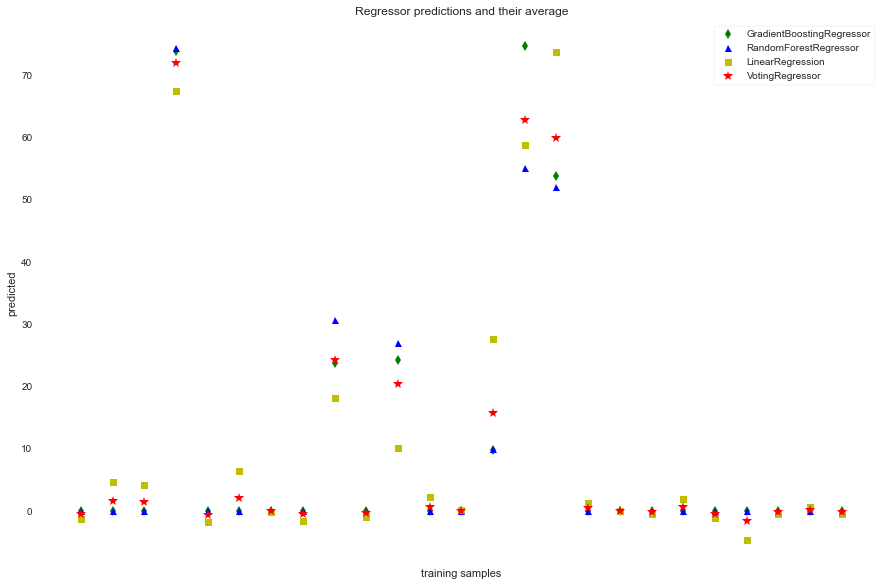

In [161]:
plt.figure(figsize = (15,10))
plt.plot(pred_gbr, 'gd', label='GradientBoostingRegressor')
plt.plot(pred_rfr, 'b^', label='RandomForestRegressor')
plt.plot(pred_lr, 'ys', label='LinearRegression')
plt.plot(pred_ereg, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('Predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

It looks like the VotingRegression algorithm is producing a nice average of the wild swings between the different base regressors.

In [22]:
y_test_mini = y_test[:25]

print(f'Gradient Boosting Regressor R^2: {reg_gbr.score(xt,y_test_mini):.3f}',
      f'\nRandom Forest Regressor R^2: {reg_rfr.score(xt,y_test_mini):.3f}',
     f'\nLinear Regression R^2: {reg_lr.score(xt,y_test_mini):.3f}',
     f'\nVoting Regressor R^2: {ereg.score(xt,y_test_mini):.3f}')

Gradient Boosting Regressor R^2: 0.930 
Random Forest Regressor R^2: 0.946 
Linear Regression R^2: 0.930 
Voting Regressor R^2: 0.966


In [26]:
# combining actual values & predictions into one table
model_performance = pd.DataFrame({'ActualSHS_Offers':y_test_mini, 'gbr':pred_gbr, 
                                  'rfr':pred_rfr, 'lr':pred_lr, 'ereg':pred_ereg})

model_performance.to_csv('../data/interim/model_performance.csv')

Given the R^2 scores are so close, I'll lean towards simplicity rather than running several base regressors and an ensemble to gain just a 3% gain in explained behavior/R^2 by choosing to do a **linear regression** going forward.

#### A bit more exploration ####

Taking a quick look at heatmap, there was strong correlation between the percent of test takers in a school and the number of offers that that high school received.

One approach that a high school can adopt to increase the number of offers is simply to increase the number of qualified students taking the speacialized high scool admission test (PerDidSHSAT). A 'qualified' student in this case is one that has an average ELL & Math score (AvgMark) that's on the higher end.

The model is based on 530 schools (536 schools with at least 6 SHSAT takers, as SHSAT is unknown for category 0-5 takers. For 6 out of those 536 schools the AvgMark is 0 as a result.

                                 OLS Regression Results                                
Dep. Variable:            PerDidSHSAT   R-squared (uncentered):                   0.820
Model:                            OLS   Adj. R-squared (uncentered):              0.820
Method:                 Least Squares   F-statistic:                              2412.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):                   3.24e-199
Time:                        15:11:50   Log-Likelihood:                         -2233.7
No. Observations:                 530   AIC:                                      4469.
Df Residuals:                     529   BIC:                                      4474.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'Percent of Students taking SHSAT')

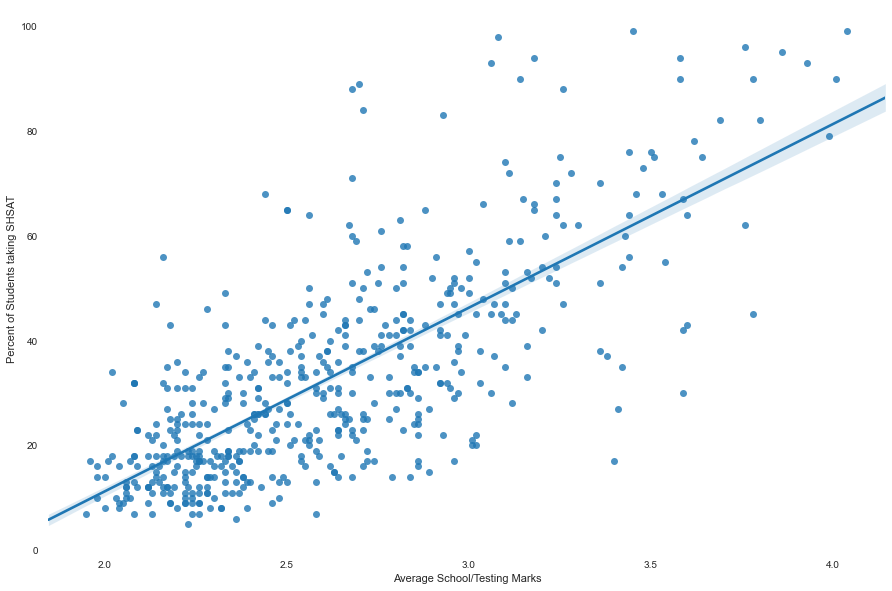

In [209]:
import statsmodels.api as sm

df_shsat = df_analysis[(df_analysis.NumTestTakers > 0) & (df_analysis.AvgMark > 0)]

# Fit and summarize OLS model
mod = sm.OLS(df_shsat.PerDidSHSAT, df_shsat.AvgMark)
res = mod.fit()
print(res.summary())

# Plot the relationship between PerDidSHSAT & AvgMark
plt.figure(figsize = (15,10))
sns.regplot(data = df_shsat, x = 'AvgMark', y = 'PerDidSHSAT', ci=68, truncate=False)
plt.xlabel('Average School/Testing Marks')
plt.ylabel('Percent of Students taking SHSAT')

**Top 25 Schools that can send more students to take the test**

Below, are the predictions by school regarding the percent of students that could have taken the SHSAT (PerModelDidSHSAT). The PotentialTakers takes the difference between the PerModelDidSHSAT and PerDidSHSAT (ModAgainstDidSHSAT) multiplied by the total number of 8th grade students in each school (count_of_students_hs_admissions).

In [225]:
pd.options.mode.chained_assignment = None

df_shsat.loc[:,'PerModelDidSHSAT'] = res.predict()
df_shsat['ModAgainstDidSHSAT'] = df_shsat.PerModelDidSHSAT - df_shsat.PerDidSHSAT
df_shsat['PotentialTakers'] = round((df_shsat.ModAgainstDidSHSAT/100) * 
                                    df_shsat.count_of_students_in_hs_admissions)

In [229]:
df_shsat[['feeder_school_name', 'count_of_students_in_hs_admissions', 'NumTestTakers', 'PerDidSHSAT', 
          'PerModelDidSHSAT', 'PotentialTakers', 'PctBlackOrHispanic']].sort_values('PotentialTakers', 
                                                                                    ascending = False).head(25)

,feeder_school_name,count_of_students_in_hs_admissions,NumTestTakers,PerDidSHSAT,PerModelDidSHSAT,PotentialTakers,PctBlackOrHispanic
357,I.S. 061 LEONARDO DA VINCI,716.0,93.0,13.0,31.590739,133.0,92
464,I.S. 034 TOTTENVILLE,378.0,81.0,21.0,39.620051,70.0,11
468,I.S. 061 WILLIAM A MORRIS,325.0,40.0,12.0,31.327482,63.0,78
402,J.H.S. 210 ELIZABETH BLACKWELL,640.0,169.0,26.0,34.486556,54.0,67
450,I.S. 145 JOSEPH PULITZER,581.0,137.0,24.0,32.907019,52.0,90
397,M.S. 137 AMERICA'S SCHOOL OF HEROES,642.0,179.0,28.0,36.066093,52.0,37
361,I.S. 093 RIDGEWOOD,378.0,78.0,21.0,33.696788,48.0,72
359,I.S. 077,345.0,61.0,18.0,30.800970,44.0,79
403,J.H.S. 226 VIRGIL I. GRISSOM,331.0,58.0,18.0,31.064226,43.0,55
433,I.S. 238 - SUSAN B. ANTHONY ACADEMY,529.0,123.0,23.0,30.800970,41.0,67


Above are the top 25 schools that are able to send more students to the SHSAT based on their average testing grades. 

**Recommendation #1** 
- The above-referenced schools ought to send more students to take the SHSAT as their average marks may translate into more of their students receiving offers to attend the specialized high schools. 
- Increasing the number of test-takers from schools with higher percentages of Black &/or Latinx test-takers will help address the deep disparity of offers being received by White and Asian students.

The caveat is that this recommendation only deals with the schools with at least 6 SHSAT Takers.

#### Offers Based on Scores of 4 ####

All possible performance related predictors (mark and level4) are very strongly correlated with each other (multicolinear). Another way to look at what can predict (successful) performance on the SHSAT is to look at percent of offers by student (PctOffersByStudent) that took the SHSAT to the percent of level-4 students in 7th grade (PctScore4).

                                 OLS Regression Results                                
Dep. Variable:     PctOffersByStudent   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              1268.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):                    1.25e-65
Time:                        20:26:42   Log-Likelihood:                         -443.30
No. Observations:                 121   AIC:                                      888.6
Df Residuals:                     120   BIC:                                      891.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Text(0, 0.5, 'Percent of Offers per Student Taking SHSAT')

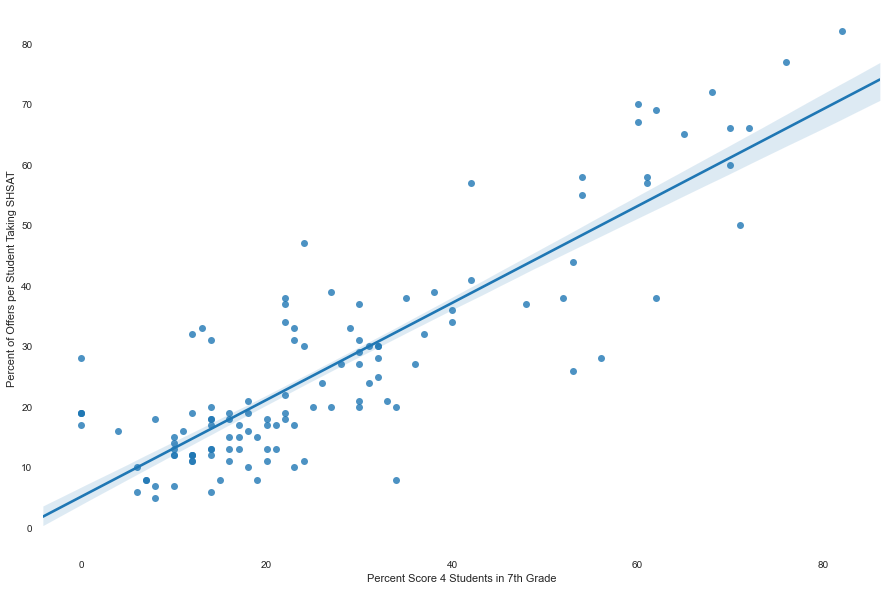

In [233]:
df_score4 = df_analysis[df_analysis.NumSpecializedOffers > 0]

# Fit and summarize OLS model
mod_offers = sm.OLS(df_score4.PctOffersByStudent, df_score4.PctScore4)
res_offers = mod_offers.fit()
print(res_offers.summary())

# Plot the relationship between PerDidSHSAT & AvgMark
plt.figure(figsize = (15,10))
sns.regplot(data = df_score4, x = 'PctScore4', y = 'PctOffersByStudent', ci=68, truncate=False)
plt.xlabel('Percent Score 4 Students in 7th Grade')
plt.ylabel('Percent of Offers per Student Taking SHSAT')

**Top 25 schools that can increase the percet of their student receiving offers** 

Here I'm making predictions by school regarding the percent of offers per student according to the model (mod_offers). Real offers (RealOffers) looks at the modeled percent offers (PctModelOffers) multiplied by the number of SHSAT takers. PotentialOffers takes the difference of RealOffers from actual offers (NumSpecializedOffers).

In [235]:
df_score4['PctModelOffers'] = res_offers.predict()
df_score4['RealOffers'] = round(df_score4.PctModelOffers * (df_score4.NumTestTakers / 100))
df_score4['PotentialOffers'] = df_score4.RealOffers - df_score4.NumSpecializedOffers

In [253]:
df_score4_under_perf = df_score4[(~df_score4.District.isin([2, 26, 3, 20, 1, 21, 15, 
                                                           25])) & (df_score4.RealOffers > 10)]

df_score4_under_perf[['feeder_school_name', 'count_of_students_in_hs_admissions', 'NumSpecializedOffers', 
                      'PctModelOffers', 'RealOffers', 'PotentialOffers', 
                      'PctBlackOrHispanic']].sort_values('PotentialOffers', ascending = False).head(25)

,feeder_school_name,count_of_students_in_hs_admissions,NumSpecializedOffers,PctModelOffers,RealOffers,PotentialOffers,PctBlackOrHispanic
334,J.H.S. 234 ARTHUR W. CUNNINGHAM,684.0,79.0,30.619022,113.0,34.0,28
411,SCHOLARS' ACADEMY,231.0,27.0,49.176006,51.0,24.0,37
276,P.S. 235 JANICE MARIE KNIGHT SCHOOL,91.0,7.0,31.546872,28.0,21.0,95
415,J.H.S. 157 STEPHEN A. HALSEY,533.0,52.0,27.835475,69.0,17.0,33
461,I.S. 024 MYRA S. BARNES,384.0,11.0,17.629134,23.0,12.0,13
424,QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SC...,83.0,23.0,57.526648,35.0,12.0,46
161,J.H.S. 118 WILLIAM W. NILES,424.0,29.0,14.845587,40.0,11.0,81
452,I.S. 227 LOUIS ARMSTRONG,460.0,27.0,18.556983,38.0,11.0,59
464,I.S. 034 TOTTENVILLE,378.0,8.0,21.340531,17.0,9.0,11
54,TAG YOUNG SCHOLARS,56.0,27.0,65.877291,36.0,9.0,44


The above table is filtered to exclude schools in eight **overperforming** districts, detailed below. "Overperforming" means total offers (NumSpecializedOffers) divided by total 8th graders (count_of_students_in_hs_admissions).


The table displays schools that should have received at least 10 Extra Offers according to the model in under and avergely performing districts.

In particular, **P.S. 235 Janice Marie Knight School** & **J.H.S. 118 William W. Niles** are great candidates that should've seen their students receive more 21 and 11 more offers, respectively, for admission to the specialized high schools, especially considering their high percentage of Black &/or Latinx students.

In [254]:
df_perf = df_analysis[['District', 'count_of_students_in_hs_admissions', 
                     'NumSpecializedOffers']].groupby(['District'], as_index = False).sum()
df_perf['Performance'] = round((df_perf.NumSpecializedOffers / df_perf.count_of_students_in_hs_admissions) * 100)
df_perf.sort_values('Performance', ascending = False).head(10)

,District,count_of_students_in_hs_admissions,NumSpecializedOffers,Performance
1,2,2551.0,493.0,19.0
25,26,2182.0,397.0,18.0
2,3,1708.0,266.0,16.0
19,20,4011.0,591.0,15.0
0,1,968.0,128.0,13.0
20,21,3088.0,363.0,12.0
14,15,2272.0,247.0,11.0
24,25,2764.0,313.0,11.0
29,30,3374.0,253.0,7.0
23,24,4569.0,252.0,6.0
